# Продвинутое машинное обучение: ДЗ 1

Первое ДЗ состоит из двух частей: первая часть про теорему Байеса и общие вероятностные рассуждения, вторая часть — про линейную регрессию. **В качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для пользователя snikolenko). Решение обязательно нужно сдать на портале Академии.**

# Импорт библиотек

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (16, 8)
legend_fontsize = 16

# Часть I: О теореме Байеса

Первая часть состоит из двух вопросов и одного задания. Смысл её в том, чтобы провести вероятностные рассуждения в ситуациях, когда модель сама по себе очень простая, но её ещё надо правильно построить, правильно отобразить жизненную ситуацию. Поэтому на первые два вопроса рекомендую давать развёрнутые ответы; эти ответы лучше писать прямо в ноутбуке, LaTeX в Jupyter работает на вполне достаточном для нас уровне.

## 1.1

### Вопрос

Произошло убийство. На месте убийства найдена кровь, которая явно (будем считать, что с вероятностью 1) принадлежит настоящему убийце. Кровь принадлежит редкой группе, которая присутствует всего лишь у 1% населения. И так получилось, что у подсудимого как раз эта редкая группа крови! Первым выходит прокурор и говорит: “Шанс, что у подсудимого была бы именно такая группа крови, если бы он был невиновен — всего 1%; значит, с вероятностью 99% он виновен, предлагаю осудить”. В чём не прав прокурор? Укажите, какие вероятности он оценил, а какие должен был оценить.

### Ответ

Пусть событие $g$ соответствует тому, что случайный человек является виновным, а событие $b$ — тому, что кровь случайного человека принадлежит редкой группе. Тогда для суждения о виновности подсудимого необходимо оценивать вероятность $p(g|b)$.

Прокурор же сделал следующие предположения:
1. $p(b | \overline g) = 0.01$, что примерно верно, если учесть, что из одного процента людей, имеющих такую группу крови, виновен должен быть всего один человек;
2. $p(g | b) = 1 - p(b | \overline g) = 0.99$, что является полной ерундой. На самом деле $1 - p(b | \overline g) = p(\overline b | \overline g)$ является вероятностью отсутствия данной редкой группы крови у случайного человека при условии его невиновности. Прокурору следовало оценить вероятность $p(\overline g | b)$, тогда вероятность $1 - p(\overline g | b) = p(g | b)$ была бы искомой величиной.

## 1.2

### Вопрос

Затем выходит адвокат, объясняет ошибки прокурора и берёт слово сам: “В городе живёт миллион человек. Это значит, что примерно у 10000 из них такая группа крови. Значит, всё, что говорит нам эта кровь — это то, что подсудимый совершил убийство с вероятностью 0,01%. Получается, что это свидетельство не просто не является строгим доказательством, а и вовсе даёт нам ничтожно малую вероятность того, что мой подзащитный виновен, так что предлагаю исключить его из материалов дела”. В чём не прав адвокат? Какие вероятности он оценил, а какие должен был оценить?

### Ответ

Адвокат утверждает следующее:
1. $p(b) = 0.01$ (верно, согласно условию);
2. $\displaystyle p(g|b) = \frac{1}{n}$, где $n = 10^4$ — число жителей с редкой группой крови. То есть адвокат предположил равномерное априорное распределение вероятности убийства случайным человеком ($\displaystyle p(g) = \frac{1}{N}$, где $N = 10^6$ — общее число жителей), и получил следующее:

$$\displaystyle p(g|b) = \frac{p(b|g) * p(g)}{p(b)} = \frac{1 * 10^{-6}}{0.01} = 10^{-4}$$

где $p(b|g) = 1$ согласно условию.

Естественно, такое предположение об априорной вероятности убийства случайным человеком в корне неверно.

## 1.3

### Вопрос

Вернёмся к тесту на страшную болезнь из первой лекции. Напомню, что по предположениям задачи болеет 1% населения, а тест имеет вероятность ошибки 5% в обе стороны. Мы видели, что в результате человек с положительным тестом имеет апостериорную вероятность оказаться больным всего лишь около 16%.

Врачи решили, что терпеть это никак нельзя; они готовы провести срочное исследование и улучшить качество теста. Но сил и денег хватит только для того, чтобы сократить один тип ошибок, то есть уменьшить или только число false positives (когда тест выдаёт положительный результат у здорового человека), или только число false negatives (когда тест выдаёт отрицательный результат у больного).

Помогите медикам: постройте зависимости апостериорной вероятности болезни после положительного и отрицательного теста от обоих видов ошибок (например, в виде графиков), сделайте выводы и дайте рекомендации врачам — на чём лучше сосредоточиться?

### Ответ

In [3]:
sick_rate = 0.01  # sick people rate
healthy_rate = 1 - sick_rate  # healthy people rate
fpr = 0.05  # false positive rate
fnr = 0.05  # false negative rate
# tpr = 1 - fnr  # true positive rate
# tnr = 1 - fpr  # true negative rate

In [4]:
def posterior_pos_test(fpr: float = 0.05, fnr: float = 0.05):
    """
    Calculate posterior probability of sickness given
    a positive test result:
    p(sick | pos_test) = p(pos_test | sick) * p(sick) / p(pos_test) = 
    p(pos_test | sick) * p(sick) / (p(pos_test | sick) * p(sick) +
    p(pos_test | healthy) * p(healthy))
    """
    tpr = 1 - fnr
    return tpr * sick_rate / (tpr * sick_rate + fpr * (1 - sick_rate))

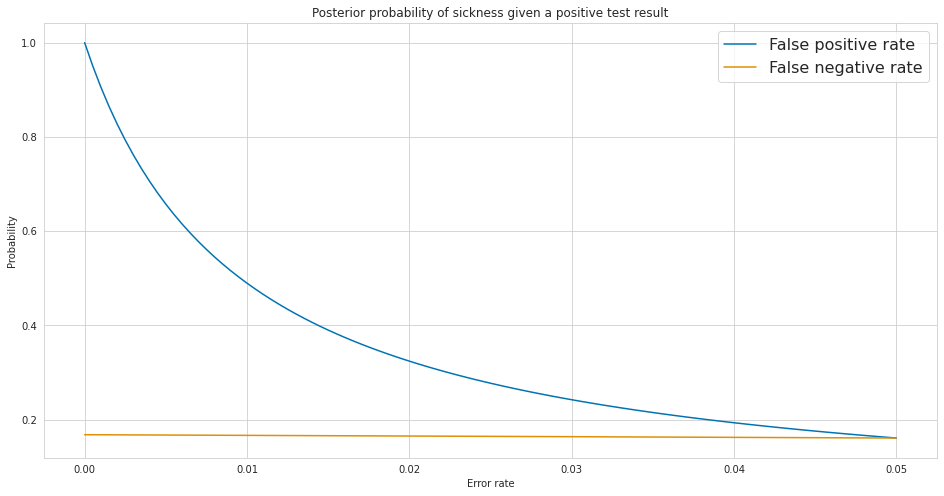

In [5]:
x = np.linspace(0.00, 0.05, 101)  # the error can change from 0 to 0.05

plt.figure(figsize=figsize)
plt.title("Posterior probability of sickness given a positive test result")
plt.plot(x, posterior_pos_test(fpr=x), label="False positive rate")
plt.plot(x, posterior_pos_test(fnr=x), label="False negative rate")
plt.xlabel("Error rate")
plt.ylabel("Probability")
plt.grid(True)
plt.legend(fontsize=legend_fontsize);

Из графика для случая положительного результата теста видно, что лучше сосредоточиться на уменьшении числа ложноположительных результатов (FPR): в таком случае положительный тест будет почти гарантированно говорить о наличии болезни.

In [6]:
def posterior_neg_test(fpr: float = 0.05, fnr: float = 0.05):
    """
    Calculate posterior probability of sickness given
    a negative test result:
    p(sick | neg_test) = p(neg_test | sick) * p(sick) / p(neg_test) = 
    p(neg_test | sick) * p(sick) / (p(neg_test | sick) * p(sick) +
    p(neg_test | healthy) * p(healthy))
    """
    tnr = 1 - fpr
    return fnr * sick_rate / (fnr * sick_rate + tnr * (1 - sick_rate))

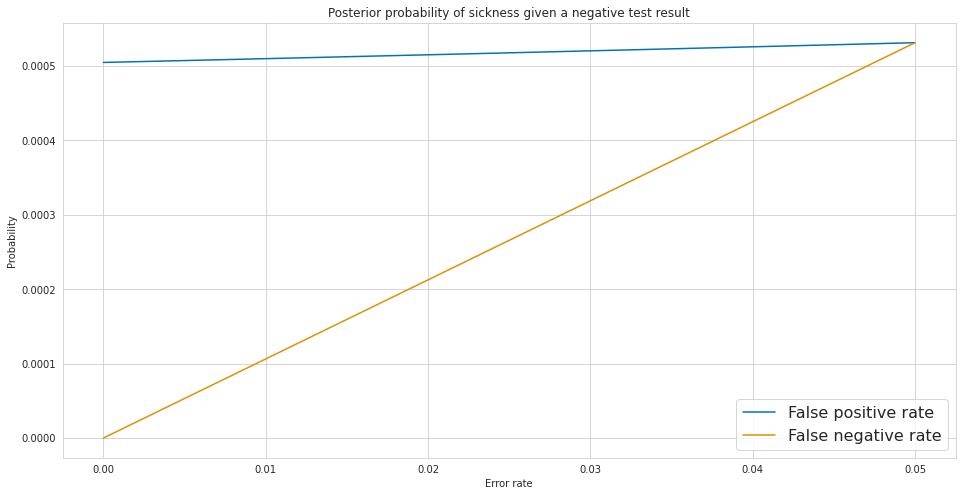

In [7]:
x = np.linspace(0.00, 0.05, 101)  # the error can change from 0 to 0.05

plt.figure(figsize=figsize)
plt.title("Posterior probability of sickness given a negative test result")
plt.plot(x, posterior_neg_test(fpr=x), label="False positive rate")
plt.plot(x, posterior_neg_test(fnr=x), label="False negative rate")
plt.xlabel("Error rate")
plt.ylabel("Probability")
plt.grid(True)
plt.legend(fontsize=legend_fontsize);

Из графика для случая отрицательного результата теста видно, что лучше сосредоточиться на уменьшении числа ложноотрицательных результатов (FNR): в таком случае отрицательный тест будет говорить о почти гарантированном отсутствии болезни.

Как можно заметить, мы получили прямо противоположные результаты. Это говорит о том, что окончательное решение о снижении того или иного вида ошибки необходимо принимать исходя из многих факторов: серьёзности болезни (можем ли мы допустить промах в тесте или нет), вредности обследования (например, многократное прохождение рентгена "для перестраховки" — не самая хорошая затея), его стоимости и сложности.

# Часть II: О линейной регрессии

Эта часть первого домашнего задания связана с анализом конкретного датасета. Датасет давайте возьмём довольно релевантный реальной жизни; он доступен по следующей ссылке: https://ourworldindata.org/coronavirus-source-data

## 2.1

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы `total_cases` и `new_cases`); для упрощения обработки можно заменить в столбце `new_cases` все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания). Иначе говоря, мы будем "играть" за российские власти, которые пытаются понять, что делать, глядя на данные об эпидемии в мае 2020 года.

In [8]:
# Download dataset
!wget -q https://covid.ourworldindata.org/data/owid-covid-data.csv

In [9]:
# Define dates
START_DATE = datetime(2020, 3, 3)
MAY_FIRST = (datetime(2020, 5, 1) - START_DATE).days
JUNE_FIRST = (datetime(2020, 6, 1) - START_DATE).days
SEPTEMBER_FIRST = (datetime(2020, 9, 1) - START_DATE).days

In [10]:
# Read dataset
df = pd.read_csv("/content/owid-covid-data.csv")
print(df.shape)

(71494, 59)


In [11]:
# Drop all unnesessary columns
cols_to_get = ["date", "location", "total_cases", "new_cases"]
df = df[cols_to_get]

# Cast date column to datetime type
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

df.head()

,date,location,total_cases,new_cases
0,2020-02-24,Afghanistan,1.0,1.0
1,2020-02-25,Afghanistan,1.0,0.0
2,2020-02-26,Afghanistan,1.0,0.0
3,2020-02-27,Afghanistan,1.0,0.0
4,2020-02-28,Afghanistan,1.0,0.0


In [12]:
# Get data for Russia
df_russia = df[df["location"] == "Russia"]
print(df_russia.shape)
df_russia.head()

(393, 4)


,date,location,total_cases,new_cases
52890,2020-01-31,Russia,2.0,2.0
52891,2020-02-01,Russia,2.0,0.0
52892,2020-02-02,Russia,2.0,0.0
52893,2020-02-03,Russia,2.0,0.0
52894,2020-02-04,Russia,2.0,0.0


In [13]:
# Drop all data before START_DATE
df_russia = df_russia[df_russia["date"] >= START_DATE]
print(df_russia.shape)
df_russia.head()

(361, 4)


,date,location,total_cases,new_cases
52922,2020-03-03,Russia,3.0,0.0
52923,2020-03-04,Russia,3.0,0.0
52924,2020-03-05,Russia,4.0,1.0
52925,2020-03-06,Russia,13.0,9.0
52926,2020-03-07,Russia,13.0,0.0


In [14]:
# Replace all zeros with ones for the new_cases column
df_russia.loc[df_russia["new_cases"] == 0, "new_cases"] = 1
print(df_russia.shape)
df_russia.head()

(361, 4)


,date,location,total_cases,new_cases
52922,2020-03-03,Russia,3.0,1.0
52923,2020-03-04,Russia,3.0,1.0
52924,2020-03-05,Russia,4.0,1.0
52925,2020-03-06,Russia,13.0,9.0
52926,2020-03-07,Russia,13.0,1.0


In [15]:
# Convert date to current day number
df_russia["day"] = (df["date"] - START_DATE).dt.days

In [16]:
russia_train = df_russia.iloc[:50]
russia_test = df_russia.iloc[50:]

In [17]:
russia_train.head()

,date,location,total_cases,new_cases,day
52922,2020-03-03,Russia,3.0,1.0,0
52923,2020-03-04,Russia,3.0,1.0,1
52924,2020-03-05,Russia,4.0,1.0,2
52925,2020-03-06,Russia,13.0,9.0,3
52926,2020-03-07,Russia,13.0,1.0,4


## 2.2

Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

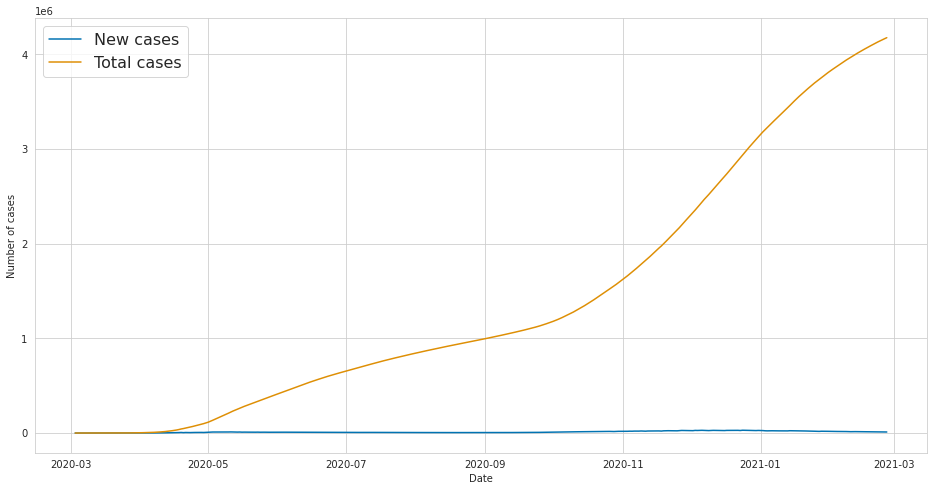

In [18]:
plt.figure(figsize=figsize)
plt.plot(df_russia["date"], df_russia["new_cases"], label="New cases")
plt.plot(df_russia["date"], df_russia["total_cases"], label="Total cases")
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Number of cases")
plt.legend(fontsize=legend_fontsize);

### 2.2.a

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: _y ~ exp(линейная функция от x)_, где x — номер текущего дня.

Представим функцию числа заболевших в виде:

$\displaystyle y \sim e^{kx + b}$.

Логарифмируем обе части выражения и получим:

$\displaystyle log(y) \sim log(e^{kx + b}) = kx + b$.

Обучим модель с единственным признаком — номером текущего дня, и целевой переменной — логарифмом числа заболевших.

In [19]:
model = LinearRegression()

In [20]:
model.fit(russia_train["day"].values.reshape(-1, 1), np.log(russia_train["total_cases"]))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

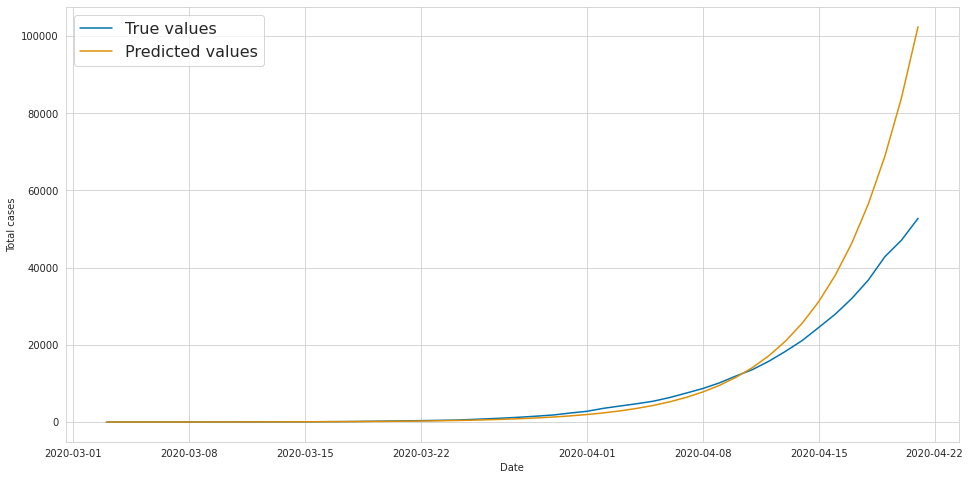

In [21]:
prediction = model.predict(russia_train["day"].values.reshape(-1, 1))

plt.figure(figsize=figsize)
plt.plot(
    russia_train["date"],
    russia_train["total_cases"],
    label="True values"
)
plt.plot(
    russia_train["date"],
    np.exp(prediction),
    label="Predicted values"
)
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Total cases")
plt.legend(fontsize=legend_fontsize);

### 2.2.b

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

Оценим дисперсию шума данных согласно следующей формуле:
$$\displaystyle \sigma^2 = \frac{1}{N} \sum_{n=1}^{N}(y_n - w^T \Phi(x_n))^2$$

In [22]:
sigma_noise = np.mean((np.log(russia_train["total_cases"]) - prediction) ** 2)

Найдём апостериорное распределение параметров модели:

$$\displaystyle \Sigma_n = (\Sigma_0^{-1} + \frac{1}{\sigma^2}\Phi^T\Phi)^{-1}$$

In [23]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) *
                            np.matmul(np.transpose(x), x) )
    mu_n = np.matmul(sigma_n,
                     np.matmul(np.linalg.inv(sigma), np.transpose(mu)) +
                     (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), y))
    return mu_n, sigma_n

In [24]:
x = np.column_stack([np.ones(russia_train.shape[0]), russia_train["day"]])

mu, sigma = bayesian_update(np.zeros(2),
                            1000 * np.eye(2),
                            x,
                            np.log(russia_train["total_cases"]).values,
                            sigma_noise)

In [25]:
print(f"W mean:\n{mu}")
print(f"W variance:\n{sigma}")

W mean:
[1.82073506 0.19829098]
W variance:
[[ 1.15248767e-03 -3.49238688e-05]
 [-3.49238688e-05  1.42546446e-06]]


### 2.2.c

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая 2020 года? К 1 июня? К 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [26]:
n_samples = 500
w = np.random.multivariate_normal(mu, sigma, n_samples)

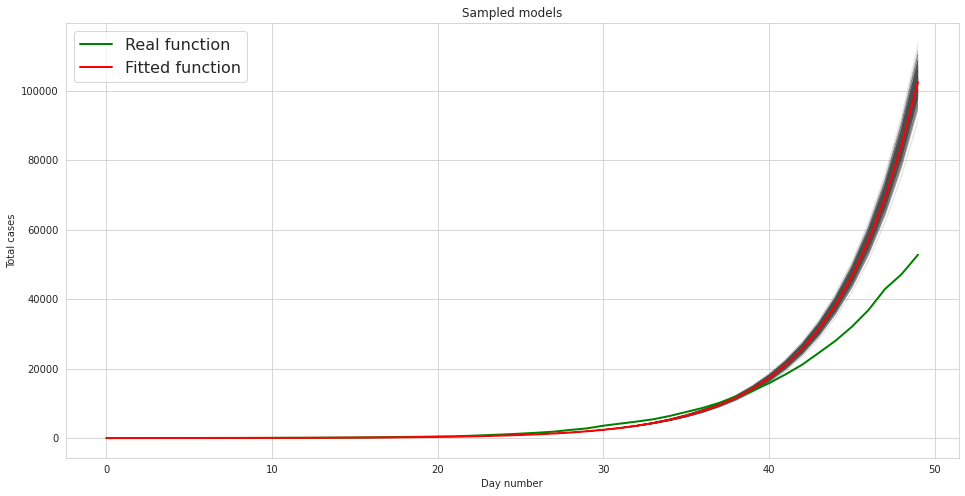

In [27]:
plt.figure(figsize=figsize)
plt.title("Sampled models")
for i in range(n_samples):
    plt.plot(russia_train["day"], np.exp(x.dot(w[i])),
             color="0.3", linewidth=.1)
plt.plot(russia_train["day"], russia_train["total_cases"],
         label="Real function", color="g", linewidth=2)
plt.plot(russia_train["day"], np.exp(prediction),
         label="Fitted function", color="r", linewidth=2)
plt.xlabel("Day number")
plt.ylabel("Total cases")
plt.legend(fontsize=legend_fontsize);

In [28]:
x = pd.Series([
    MAY_FIRST,
    JUNE_FIRST,
    SEPTEMBER_FIRST
])

pred_matrix = np.column_stack([np.ones(3), x])

res = np.exp(w.dot(pred_matrix.T))

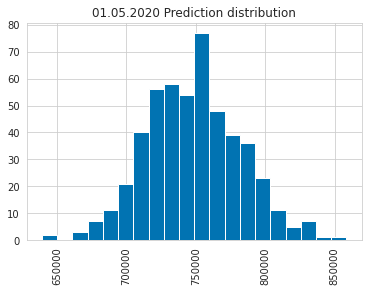

In [29]:
plt.hist(res[:, 0], bins=20)
plt.xticks(rotation=90)
plt.title("01.05.2020 Prediction distribution");

In [30]:
# Prediction for May 1
print(f"Median:\t\t{round(np.quantile(res[:, 0], 0.5))}")
print(f"10-quantile:\t{round(np.quantile(res[:, 0], 0.1))}")
print(f"90-quantile:\t{round(np.quantile(res[:, 0], 0.9))}")
print(f"True value:\t" \
      f"{russia_test[russia_test['day'] == MAY_FIRST]['total_cases'].iloc[0]}")

Median:		748574
10-quantile:	706740
90-quantile:	792108
True value:	114431.0


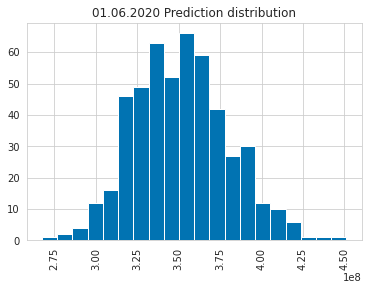

In [31]:
plt.hist(res[:, 1], bins=20)
plt.xticks(rotation=90)
plt.title("01.06.2020 Prediction distribution");

In [32]:
# Prediction for June 1
print(f"Median:\t\t{round(np.quantile(res[:, 1], 0.5))}")
print(f"10-quantile:\t{round(np.quantile(res[:, 1], 0.1))}")
print(f"90-quantile:\t{round(np.quantile(res[:, 1], 0.9))}")
print(f"True value:\t" \
      f"{russia_test[russia_test['day'] == JUNE_FIRST]['total_cases'].iloc[0]}")

Median:		351369571
10-quantile:	316940916
90-quantile:	390196559
True value:	414328.0


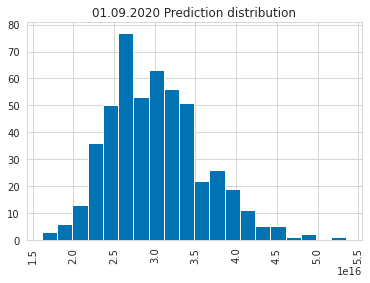

In [33]:
plt.hist(res[:, 2], bins=20)
plt.xticks(rotation=90)
plt.title("01.09.2020 Prediction distribution");

In [34]:
# Prediction for September 1
print(f"Median:\t\t{round(np.quantile(res[:, 2], 0.5))}")
print(f"10-quantile:\t{round(np.quantile(res[:, 2], 0.1))}")
print(f"90-quantile:\t{round(np.quantile(res[:, 2], 0.9))}")
print(f"True value:\t" \
      f"{russia_test[russia_test['day'] == SEPTEMBER_FIRST]['total_cases'].iloc[0]}")

Median:		29561732788604504
10-quantile:	23239072906485444
90-quantile:	37911977312211104
True value:	997072.0


## 2.3

Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

$$\displaystyle \Phi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^x \mathrm{e}^{-t^2/2}\,\mathrm{d}t$$

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от _t_.

### 2.3.a

Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Представим произвольную квадратичную функцию в экспоненте под интегралом в виде
$$\displaystyle at^2 + bt + c$$
Тогда уравнение сигмоиды можно представить в виде:
$$\displaystyle y(x) = k\int_{-\infty}^{x}\mathrm{e}^{at^2 + bt + c}\mathrm{d}t = \int_{-\infty}^{x}\mathrm{e}^{\mathrm{log}k}\mathrm{e}^{at^2 + bt + c}\mathrm{d}t = \int_{-\infty}^{x}\mathrm{e}^{at^2 + bt + c'}\mathrm{d}t$$
Диапазон номеров дней для расчёта предсказаний начинается не на минус бесконечности, а в нуле, и имеет дискретный вид. С учётом этого, получим:
$$\displaystyle \mathrm{log}(y_i - y_{i - 1}) = ax^2 + bx + c'$$
Таким образом, для обучения модели в качестве признаков будем использовать номер дня и его квадрат, а в качестве целевой переменной — логарифм разности текущего и предыдущего значения целевой переменной.

In [35]:
model = LinearRegression()
x = np.column_stack([russia_train["day"], russia_train["day"] ** 2])
y = np.log(russia_train["new_cases"].values)
model.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

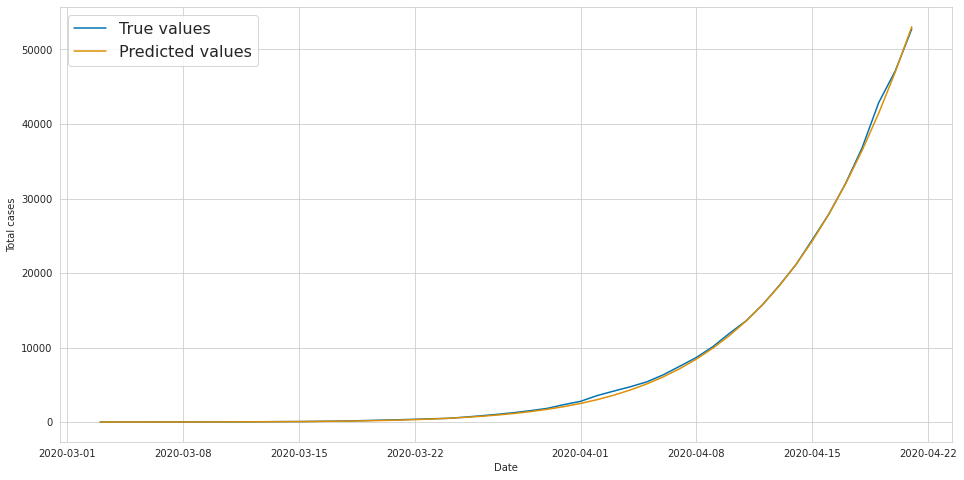

In [36]:
prediction = model.predict(x)

plt.figure(figsize=figsize)
plt.plot(
    russia_train["date"],
    russia_train["total_cases"],
    label="True values"
)
plt.plot(
    russia_train["date"],
    np.exp(prediction).cumsum(),
    label="Predicted values"
)
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Total cases")
plt.legend(fontsize=legend_fontsize);

### 2.4.b

Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [37]:
sigma_noise = np.mean((y - prediction) ** 2)

In [38]:
x = np.column_stack([np.ones_like(russia_train["day"]), x])

mu, sigma = bayesian_update(
    np.zeros(3),
    1000 * np.eye(3),
    x,
    y,
    sigma_noise
)

In [39]:
print(f"W mean:\n{mu}")
print(f"W variance:\n{sigma}")

W mean:
[-0.39658641  0.2756225  -0.00182979]
W variance:
[[ 9.52394107e-03 -7.69480531e-04  1.29542176e-05]
 [-7.69480531e-04  8.48437326e-05 -1.61928267e-06]
 [ 1.29542176e-05 -1.61928267e-06  3.30466208e-08]]


### 2.4.c

Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [40]:
n_samples = 500
w = np.random.multivariate_normal(mu, sigma, n_samples)

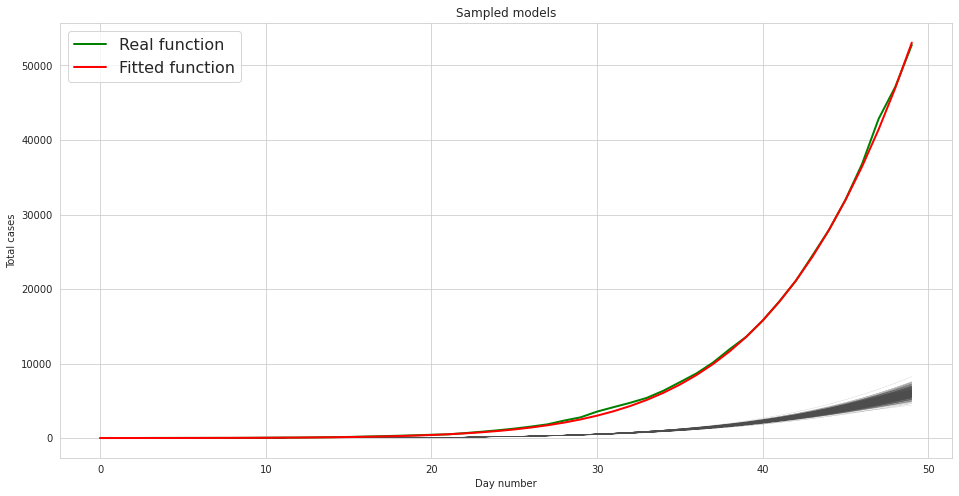

In [41]:
plt.figure(figsize=figsize)
plt.title("Sampled models")
for i in range(n_samples):
    plt.plot(russia_train["day"], np.exp(x.dot(w[i])),
             color="0.3", linewidth=.1)
plt.plot(russia_train["day"], russia_train["total_cases"],
         label="Real function", color="g", linewidth=2)
plt.plot(russia_train["day"], np.exp(prediction).cumsum(),
         label="Fitted function", color="r", linewidth=2)
plt.xlabel("Day number")
plt.ylabel("Total cases")
plt.legend(fontsize=legend_fontsize);

In [42]:
x = np.arange(SEPTEMBER_FIRST + 1)

pred_matrix = np.column_stack([np.ones(x.shape[0]), x, x ** 2])

res = np.exp(w.dot(pred_matrix.T)).cumsum(1)

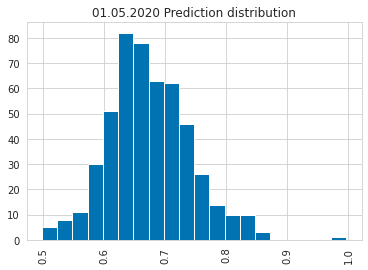

In [43]:
plt.hist(res[:, 0], bins=20)
plt.xticks(rotation=90)
plt.title("01.05.2020 Prediction distribution");

In [44]:
# Prediction for May 1
print(f"Median:\t\t{round(np.quantile(res[:, 0], 0.5))}")
print(f"10-quantile:\t{round(np.quantile(res[:, 0], 0.1))}")
print(f"90-quantile:\t{round(np.quantile(res[:, 0], 0.9))}")
print(f"True value:\t" \
      f"{russia_test[russia_test['day'] == MAY_FIRST]['total_cases'].iloc[0]}")

Median:		1
10-quantile:	1
90-quantile:	1
True value:	114431.0


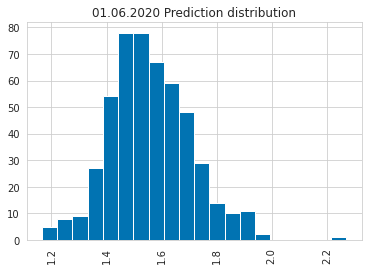

In [45]:
plt.hist(res[:, 1], bins=20)
plt.xticks(rotation=90)
plt.title("01.06.2020 Prediction distribution");

In [46]:
# Prediction for June 1
print(f"Median:\t\t{round(np.quantile(res[:, 1], 0.5))}")
print(f"10-quantile:\t{round(np.quantile(res[:, 1], 0.1))}")
print(f"90-quantile:\t{round(np.quantile(res[:, 1], 0.9))}")
print(f"True value:\t" \
      f"{russia_test[russia_test['day'] == JUNE_FIRST]['total_cases'].iloc[0]}")

Median:		2
10-quantile:	1
90-quantile:	2
True value:	414328.0


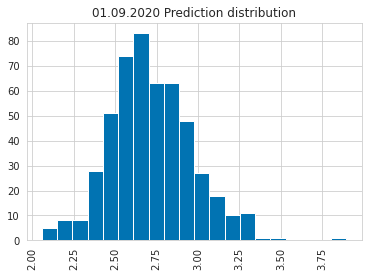

In [47]:
plt.hist(res[:, 2], bins=20)
plt.xticks(rotation=90)
plt.title("01.09.2020 Prediction distribution");

In [48]:
# Prediction for September 1
print(f"Median:\t\t{round(np.quantile(res[:, 2], 0.5))}")
print(f"10-quantile:\t{round(np.quantile(res[:, 2], 0.1))}")
print(f"90-quantile:\t{round(np.quantile(res[:, 2], 0.9))}")
print(f"True value:\t" \
      f"{russia_test[russia_test['day'] == SEPTEMBER_FIRST]['total_cases'].iloc[0]}")

Median:		3
10-quantile:	2
90-quantile:	3
True value:	997072.0


## 2.4

_Бонус_: проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

## 2.5

_[Эта часть задания не оценивается, здесь нет правильных и неправильных ответов, но буду рад узнать, что вы думаете]_ Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?